In [1]:
import os
os.environ['J_NOTEBOOK'] = '1'

from preprocess.preprocess import *
import PARAMETERS
import sys
sys.path.append('./preprocess/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline


PARAMETERS.PREPROCESS_OPTIMIZATION = True

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'DRIVE'
TRAIN_SIZE = 14 if PARAMETERS.DATASET != 'CHASE' else 20
TOTAL_SIZE = 20 if PARAMETERS.DATASET != 'CHASE' else 28

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu,get_pyramid_dataset,lanczos,False,5,True,True


In [2]:
# Get CV folds

import pandas as pd
import numpy as np

preprocess = Preprocess(
    lbp_radius=1,
    lbp_method=PARAMETERS.LBP_METHOD,
    height={'DRIVE': 608, 'CHASE': 960, 'STARE': 608}[PARAMETERS.DATASET],
    width={'DRIVE': 576, 'CHASE': 1024, 'STARE': 704}[PARAMETERS.DATASET],
    balance=PARAMETERS.BALANCE
)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:TRAIN_SIZE]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

print(pixel_ref)
cv_folds = {}

for i, j in enumerate(range(0, TRAIN_SIZE, round(TRAIN_SIZE/5))):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+round(TRAIN_SIZE/5)-1, TRAIN_SIZE-1)][1])
    

{0: (0, 225600), 1: (225600, 453286), 2: (453286, 681473), 3: (681473, 909199), 4: (909199, 1136561), 5: (1136561, 1361653), 6: (1361653, 1589479), 7: (1589479, 1816806), 8: (1816806, 2044115), 9: (2044115, 2271374), 10: (2271374, 2499075), 11: (2499075, 2724019), 12: (2724019, 2951757), 13: (2951757, 3178299)}


In [3]:
import pandas as pd

df_train = pd.DataFrame()
df_test = pd.DataFrame()

#for conf in ['_blue', '_blue_lbp_gb', '_green', '_green_lbp_gb']:
for conf in ['_green_lbp_g']:

    df_train_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_train_riu.columns]
    df_test_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_test_riu.columns]

    if df_train.shape[0] == 0:
        y_train = df_train_riu['label']
        y_test = df_test_riu['label']
    df_train_riu = df_train_riu.drop(['label'], axis=1)
    df_test_riu = df_test_riu.drop(['label'], axis=1)


    df_train_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_train_var.columns]
    df_test_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_test_var.columns]

    df_train_var = df_train_var.drop(['Original', 'label'], axis=1)
    df_test_var = df_test_var.drop(['Original', 'label'], axis=1)

    df_train_temp = pd.concat([df_train_riu, df_train_var], axis=1)
    df_test_temp = pd.concat([df_test_riu, df_test_var], axis=1)
    df_train_temp.columns = [c + conf for c in df_train_temp.columns]
    df_test_temp.columns = [c + conf for c in df_test_temp.columns]

    if df_train.shape[0] > 0:
        df_train_temp.index = df_train.index
        df_test_temp.index = df_test.index
    df_train = pd.concat([df_train, df_train_temp], axis=1)
    df_test = pd.concat([df_test, df_test_temp], axis=1)
    
display(df_train)
display(df_test)

,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,2.0,35.0,8.0,8.0,8.0,9.0,9.0,16.0,8.0,18.049300,2691.523366,2816.494723,2134.944450,11.493193,9.448573,17.435591,15.057359
1,2.0,34.0,8.0,8.0,8.0,9.0,0.0,8.0,34.0,37.541454,2691.523366,2816.494723,2134.944450,8.447647,6.260227,12.963602,10.813002
2,2.0,34.0,8.0,8.0,8.0,9.0,1.0,27.0,35.0,64.923163,2728.380278,2755.308975,2134.944450,5.959122,3.510395,6.007235,3.377165
3,2.0,4.0,8.0,8.0,8.0,9.0,9.0,34.0,34.0,90.715861,2728.380278,2755.308975,2134.944450,2.464777,1.080965,3.878203,5.703805
4,2.0,27.0,8.0,8.0,8.0,9.0,1.0,34.0,34.0,107.285915,2746.841934,2755.308975,2134.944450,0.593639,0.816103,7.692123,7.171601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,3.0,16.0,8.0,35.0,8.0,8.0,8.0,35.0,35.0,831.932087,731.033413,1344.736959,1822.496624,360.764386,342.393769,88.019078,66.964242
226538,3.0,4.0,8.0,35.0,8.0,8.0,8.0,35.0,35.0,649.954725,731.033413,1344.736959,1822.496624,549.212369,677.907122,53.993511,35.221283
226539,3.0,8.0,16.0,35.0,8.0,8.0,4.0,8.0,16.0,389.032615,717.984941,1432.625419,1822.496624,271.868208,57.896099,19.599378,6.102433
226540,2.0,27.0,16.0,35.0,8.0,2.0,1.0,8.0,34.0,133.587029,717.984941,1432.625419,1822.496624,10.479992,3.561978,3.355944,0.889331


,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,1:2_var_green_lbp_g,1:4_var_green_lbp_g,1:8_var_green_lbp_g,2:1_1_var_green_lbp_g,2:1_2_var_green_lbp_g,2:1_3_var_green_lbp_g,2:1_4_var_green_lbp_g
0,3.0,4.0,35.0,8.0,8.0,1.0,9.0,34.0,35.0,6.954297,101.574460,1150.728568,898.272755,2.698548,3.608622,2.223276,1.876082
1,3.0,4.0,35.0,8.0,8.0,1.0,9.0,35.0,34.0,3.466316,101.574460,1150.728568,898.272755,3.586646,4.724168,2.273066,2.642552
2,3.0,2.0,8.0,8.0,8.0,1.0,9.0,35.0,35.0,1.762458,131.991801,1150.728568,898.272755,4.532919,5.282802,3.033254,3.152247
3,3.0,9.0,8.0,8.0,8.0,1.0,1.0,27.0,27.0,0.932945,131.991801,1150.728568,898.272755,4.669947,4.378025,4.205974,5.434448
4,3.0,4.0,31.0,4.0,8.0,1.0,1.0,27.0,27.0,3.466316,164.566767,979.405645,898.272755,6.681710,7.579463,3.215237,2.928628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226969,2.0,6.0,35.0,4.0,8.0,26.0,4.0,6.0,8.0,6.983381,421.057276,683.573134,761.754830,2.494801,3.856601,0.628950,1.626841
226970,2.0,34.0,35.0,4.0,8.0,8.0,16.0,35.0,35.0,24.654873,421.057276,683.573134,761.754830,7.897857,7.952501,1.014407,0.565263
226971,2.0,35.0,4.0,8.0,4.0,2.0,27.0,3.0,1.0,12.825603,256.615122,651.463164,843.281428,2.065825,2.649209,0.937004,0.721403
226972,2.0,27.0,4.0,8.0,4.0,35.0,35.0,9.0,1.0,34.017418,256.615122,651.463164,843.281428,2.073544,1.962023,2.500048,2.147529


In [4]:
# CV

from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def cross_validate_features(features, verbose=True):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(df_train_temp, y_train_temp.values.ravel(), lgb='Num')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}


cross_validate_features({'x_train': df_train, 'y_train':y_train})

Accuracy score: 0.9248789020254654

F1 score: 0.6668228648040038

Confusion matrix:

     t/p    0.0   1.0 
      0.0 579051 26258 
      1.0 24935 51229 
Sensivity: 0.6726143584895752
Specificity: 0.9566205029166921
-------------------------------------
Accuracy score: 0.9189317533594049

F1 score: 0.643674595635513

Confusion matrix:

     t/p    0.0   1.0 
      0.0 575235  7570 
      1.0 47571 49804 
Sensivity: 0.5114659820282413
Specificity: 0.9870110929041446
-------------------------------------
Accuracy score: 0.9312093567114359

F1 score: 0.7005873836871879

Confusion matrix:

     t/p    0.0   1.0 
      0.0 580590 12854 
      1.0 34093 54925 
Sensivity: 0.6170100429126694
Specificity: 0.9783399950121663
-------------------------------------
Accuracy score: 0.9381118510848591

F1 score: 0.669587750294464

Confusion matrix:

     t/p    0.0   1.0 
      0.0 595190 11984 
      1.0 30094 42636 
Sensivity: 0.5862230166368761
Specificity: 0.9802626594682908
--------------------

{'acc': 0.9253784198317954, 'f1': 0.6648381467607385}

Columns: Index(['Original_green_lbp_g', '1:1_riu_green_lbp_g', '1:2_riu_green_lbp_g',
       '1:4_riu_green_lbp_g', '1:8_riu_green_lbp_g', '2:1_1_riu_green_lbp_g',
       '2:1_2_riu_green_lbp_g', '2:1_3_riu_green_lbp_g',
       '2:1_4_riu_green_lbp_g', '1:1_var_green_lbp_g', '1:2_var_green_lbp_g',
       '1:4_var_green_lbp_g', '1:8_var_green_lbp_g', '2:1_1_var_green_lbp_g',
       '2:1_2_var_green_lbp_g', '2:1_3_var_green_lbp_g',
       '2:1_4_var_green_lbp_g'],
      dtype='object')


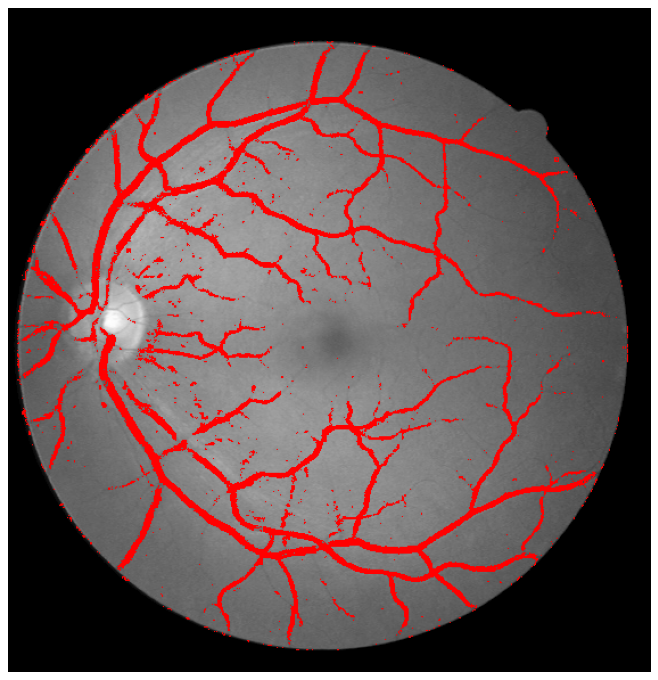

Accuracy score: 0.9335748623878795

F1 score: 0.7172761459751877

Confusion matrix:

     t/p    0.0   1.0 
      0.0 1157366 30179 
      1.0 60339 114823 
Sensivity: 0.6555246000844932
Specificity: 0.9745870682795178


(0.934, 0.717, 1157366, 30179, 60339, 114823)

In [5]:
features = {
    'x_train': df_train,
    'x_test': df_test,
    'y_train': y_train,
    'y_test': y_test
}

from main import main
PARAMETERS.PLOT = True
PARAMETERS.DATASET = 'DRIVE'


main(lgb='Num', features=features, plot_once=True)